Okay, so given an arc (two half circles), and an arbitrary position in the plane, can we determine "where" on the arc we are, from 0 meaning at the start, to 1 meaning at the target (end) position?

The answer is yes we can, but how...?

In [17]:
%pylab inline
import json
import os
import numpy as np
import pickle
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
# Also grab a parameter file while we are at it
PREFIX = 'neeraj/neeraj_1_arc_28_01.14h05m34'
params = json.load(open(PREFIX+'_parameters.json'))
# Convert m to cm
for quant in ["ARC_BASE_X","ARC_BASE_Y","ARC_RADIUS_1","ARC_RADIUS_2","RIGHT_ORIGIN","LEFT_ORIGIN","TARGET_RADIUS"]:
    params[quant]=100*array(params[quant])

In [8]:
def distance_to_arc(x,y,cx,cy,rad,upper):
    """ 
    Distance to an arc of a given radius around a given center point.
    If upper=True, then the arc is the "upper" half of the circle, that is it extends to HIGHER y than cy
    If upper=False, then the arc is the "lower" half of the circle, that is, it extends to LOWER y than cy
    """
    # First, check that we are in the good half of the circle
    goodhalf = (y>cy and upper) or (y<cy and not upper)
    
    if goodhalf:
        dfromcenter= sqrt((x-cx)**2+(y-cy)**2)
        return abs(dfromcenter-rad)

    # else...
    # In this case, the shortest distance to the arc is the shortest
    # distance to the edges of the arc
    dleftedge  = sqrt((x-(cx-rad))**2+(y-cy)**2)
    drightedge = sqrt((x-(cx+rad))**2+(y-cy)**2)
    return min([dleftedge,drightedge])

In [24]:
def draw_arc(ax):
    """ 
    Draw a reference arc in a given plot
    """
    col   = 'black'
    alpha =.8
    lw    = 2

    circangs = linspace(0,2*pi,100)
    
    def arc(center,radius,angs):
        cx,cy=center
        ax.plot((cx+radius*cos(angs)),
                (cy+radius*sin(angs)),color=col,alpha=alpha,lw=lw)
        # What that factor 100 is doing in there? Converting m to cm.

    arc(params["RIGHT_ORIGIN"],params["TARGET_RADIUS"],circangs)
    arc(params["LEFT_ORIGIN"] ,params["TARGET_RADIUS"],circangs)    
    
    arc((params["ARC_BASE_X"]-params["ARC_RADIUS_1"],params["ARC_BASE_Y"]),params["ARC_RADIUS_1"],linspace(0,   pi,100))
    arc((params["ARC_BASE_X"]+params["ARC_RADIUS_2"],params["ARC_BASE_Y"]),params["ARC_RADIUS_2"],linspace(pi,2*pi,100))
    ax.set_aspect('equal')

In [67]:
def halfcircle_progress(x,y,cx,cy,rad,upper):
    """ Compute the progress along a half-circle defined by center cx,cy and radius, upper """
    dx,dy = x-cx,y-cy
    dy = -dy if not upper else dy
    a = np.arctan2(dy,dx)/(2*np.pi)
    if a<-.25: a+=1 # and a>-.25: a+=1
    return a
    # TODO: if upper?

In [72]:
def arc_progress(x,y):
    """ This tells us, how much 'progress' the subject has made at this current (x,y) position.
    So when they are at the starting point, the progress will be 0 and in the target, the progress will be 1.
    This is assuming that the subject starts at the right start circle and moves to the left.
    """
    
    # Step 1: determine which half-arc (half-circle) the subject is closest to
    arcs = [ 
        (params["ARC_BASE_X"]+params["ARC_RADIUS_2"],params["ARC_BASE_Y"],params["ARC_RADIUS_2"],False),
        (params["ARC_BASE_X"]-params["ARC_RADIUS_1"],params["ARC_BASE_Y"],params["ARC_RADIUS_1"],True)
        # the last argument in the above tuples tells us whether it's an 'upward' half circle or downward.
           ]
    
    ds = [ distance_to_arc(x,y,cx,cy,rad,upper) for (cx,cy,rad,upper) in arcs ]
    curarc = argmin(ds)
    
    # Step 2: for the circle that they are closest to, compute the progress along this half-circle\
    cx,cy,rad,upper = arcs[curarc]
    p = halfcircle_progress(x,y,cx,cy,rad,upper)+.5*curarc
    
    return p

In [73]:
#f,ax = subplots(1,1)
#draw_arc(ax)
arctan2(-.01,-1)

-3.131592986903128

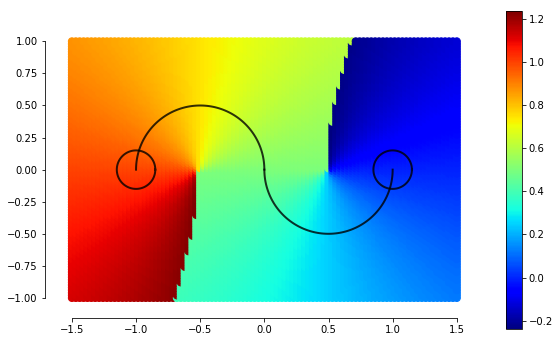

In [74]:
f,ax=subplots(1,1,figsize=(8,5))
draw_arc(ax)
#ax.plot(y,z,'-',lw=2,color='blue')
ds = [ (arc_progress(yi,zi),yi,zi) 
      for yi in linspace(-1.5,1.5,100)
      for zi in linspace(-1,1,100) ]
dz,yz,zz = zip(*ds)
plt.scatter(yz,zz,c=dz,s=50,cmap='jet')
#for _,yi,zi in traj[::20]:
#    d = dist_from_arc(yi,zi)
#    ax.plot(yi,zi,'o',color=(d*4,0,0),mec='black',mew=1,markersize=10)
tight_layout()
sns.despine(offset=5,trim=True)
colorbar()